# Gemma 7b-it 모델 No-tuned

In [ ]:
# 'input_text': '원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해태하고, 노조조합장이 사임한 경우, 노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있음에도 원고 자신이 주동하여 노조자치수습대책위원회를 구성하여 그 위원장으로 피선되어 근무시간중에도 노조활동을 벌여 운수업체인 소속회사의 업무에 지장을 초래하고 종업원들에게도 나쁜 영향을 끼쳐 소속회사가 취업규칙을 위반하고 고의로 회사업무능률을 저해하였으며 회사업무상의 지휘명령에 위반하였음을 이유로 원고를 징계해고 하였다면, 이는 원고의 노동조합 활동과는 관계없이 회사취업규칙에 의하여 사내질서를 유지하기 위한 사용자 고유의 징계권에 기하여 이루어진 정당한 징계권의 행사로 보아야 한다.'
# , 'target_text': '원고가  주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 따른 징계해고는 사내질서를 유지하기 위한 사용자 고유의 정당한 징계권의 행사로 보아야 한다.'}

## 1. 모델 및 토크나이저 로드

In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

def load_model_and_tokenizer(model_name="google/gemma-7b-it"):
    """
    BitsAndBytesConfig를 사용하여 8-bit quantization 상태로 모델을 로드합니다.
    device_map을 {"": "cuda:1"}로 설정하여 모든 모듈이 오직 cuda:1에 할당되도록 합니다.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        llm_int8_threshold=6.0,
        llm_int8_has_fp16_weight=False,
        llm_int8_enable_fp32_cpu_offload=True
    )
    
    # 모든 모듈을 cuda:1에 할당하는 커스텀 device_map 설정
    device_map = {"": "cuda:1"}
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map=device_map
    )
    return model, tokenizer

# 모델 및 토크나이저 로드 (한 번만 로드하여 이후 튜닝에 재사용)
model, tokenizer = load_model_and_tokenizer("google/gemma-7b-it")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 2. 결과 도출

In [23]:
import optuna
from rouge_score import rouge_scorer

def objective(trial):
    # 튜닝할 생성 파라미터 후보를 제안합니다.
    temperature = trial.suggest_float("temperature", 0.5, 1.0)
    top_p = trial.suggest_float("top_p", 0.7, 1.0)
    repetition_penalty = trial.suggest_float("repetition_penalty", 1.0, 2.0)
    no_repeat_ngram_size = trial.suggest_int("no_repeat_ngram_size", 2, 4)
    
    # 고정 입력 예시 및 참조 요약 (실제 튜닝 시 여러 샘플로 확장 가능)
    input_text = (
        '원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해태하고, 노조조합장이 사임한 경우, 노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있음에도 원고 자신이 주동하여 노조자치수습대책위원회를 구성하여 그 위원장으로 피선되어 근무시간중에도 노조활동을 벌여 운수업체인 소속회사의 업무에 지장을 초래하고 종업원들에게도 나쁜 영향을 끼쳐 소속회사가 취업규칙을 위반하고 고의로 회사업무능률을 저해하였으며 회사업무상의 지휘명령에 위반하였음을 이유로 원고를 징계해고 하였다면, 이는 원고의 노동조합 활동과는 관계없이 회사취업규칙에 의하여 사내질서를 유지하기 위한 사용자 고유의 징계권에 기하여 이루어진 정당한 징계권의 행사로 보아야 한다.'
    )
    reference = (
        '원고가 주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 따른 징계해고는 사내질서를 유지하기 위한 사용자 고유의 정당한 징계권의 행사로 보아야 한다.'
    )
    
    # 개선된 프롬프트 구성
    prompt = (
        f"### 원문:\n{input_text}\n\n"
        "### 요약 지시사항:\n"
        "위 원문의 핵심 내용을 정제되고 자연스러운 문어체로 3-4 문장으로 요약해 주세요. "
        "불필요한 생략 기호나 구어체 표현은 사용하지 말고, 명확하고 간결하게 작성해 주세요.\n"
        "### 요약:"
    )
    
    # gpu "cuda:1" 사용 (입력 토큰은 명시적으로 이동)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    # 모델 generate 호출 (튜닝 파라미터 반영)
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=150,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            repetition_penalty=repetition_penalty,
            no_repeat_ngram_size=no_repeat_ngram_size,
            pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id
        )
    
    generated_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # ROUGE-L를 기준으로 평가 (값이 높을수록 좋으므로, 최적화를 위해 -값을 반환)
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated_summary)
    rouge_l = scores['rougeL'].fmeasure
    # 목표: ROUGE-L을 최대화하므로, 최적화 objective는 -rouge_l (minimize 방향)
    return -rouge_l

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best trial:")
print(study.best_trial.params)


[I 2025-03-01 09:16:35,481] A new study created in memory with name: no-name-08e3ccd5-5c2d-4fe9-af1e-b35a09109606
[I 2025-03-01 09:16:38,717] Trial 0 finished with value: 0.0 and parameters: {'temperature': 0.5316556852358185, 'top_p': 0.7339060581369322, 'repetition_penalty': 1.3244939469020023, 'no_repeat_ngram_size': 3}. Best is trial 0 with value: 0.0.
[I 2025-03-01 09:16:43,801] Trial 1 finished with value: 0.0 and parameters: {'temperature': 0.940595581858298, 'top_p': 0.7365539411349434, 'repetition_penalty': 1.82119776571525, 'no_repeat_ngram_size': 2}. Best is trial 0 with value: 0.0.
[I 2025-03-01 09:16:48,287] Trial 2 finished with value: 0.0 and parameters: {'temperature': 0.676637107781165, 'top_p': 0.9940458797392224, 'repetition_penalty': 1.7924918175725328, 'no_repeat_ngram_size': 2}. Best is trial 0 with value: 0.0.
[I 2025-03-01 09:16:53,844] Trial 3 finished with value: 0.0 and parameters: {'temperature': 0.7630867004429474, 'top_p': 0.8066371126311944, 'repetition_p

Best trial:
{'temperature': 0.5316556852358185, 'top_p': 0.7339060581369322, 'repetition_penalty': 1.3244939469020023, 'no_repeat_ngram_size': 3}


## 3. 메인 함수: 전체 파이프라인 실행

In [ ]:
def generate_summary_with_params(model, tokenizer, input_text, params, max_new_tokens=150):
    """
    튜닝된 파라미터를 사용하여 입력 텍스트에 대해 요약을 생성합니다.
    """
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    prompt = (
        f"### 원문:\n{input_text}\n\n"
        "### 요약 지시사항:\n"
        "위 원문의 핵심 내용을 정제되고 자연스러운 문어체로 3-4 문장으로 요약해 주세요. "
        "불필요한 생략 기호나 구어체 표현은 사용하지 말고, 명확하고 간결하게 작성해 주세요.\n"
        "### 요약:"
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=params["temperature"],
            top_p=params["top_p"],
            repetition_penalty=params["repetition_penalty"],
            no_repeat_ngram_size=params["no_repeat_ngram_size"],
            pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id
        )
    
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

# 최적 파라미터를 얻은 후, 새로운 입력에 대해 요약 생성
best_params = study.best_trial.params
test_input = (
    '원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해태하고, 노조조합장이 사임한 경우, 노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있음에도 원고 자신이 주동하여 노조자치수습대책위원회를 구성하여 그 위원장으로 피선되어 근무시간중에도 노조활동을 벌여 운수업체인 소속회사의 업무에 지장을 초래하고 종업원들에게도 나쁜 영향을 끼쳐 소속회사가 취업규칙을 위반하고 고의로 회사업무능률을 저해하였으며 회사업무상의 지휘명령에 위반하였음을 이유로 원고를 징계해고 하였다면, 이는 원고의 노동조합 활동과는 관계없이 회사취업규칙에 의하여 사내질서를 유지하기 위한 사용자 고유의 징계권에 기하여 이루어진 정당한 징계권의 행사로 보아야 한다.'
)
final_summary = generate_summary_with_params(model, tokenizer, test_input, best_params)
print("Test Input:")
print(test_input)
print("\nFinal Generated Summary:")
print(final_summary)

Test Input:
원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해태하고, 노조조합장이 사임한 경우, 노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있음에도 원고 자신이 주동하여 노조자치수습대책위원회를 구성하여 그 위원장으로 피선되어 근무시간중에도 노조활동을 벌여 운수업체인 소속회사의 업무에 지장을 초래하고 종업원들에게도 나쁜 영향을 끼쳐 소속회사가 취업규칙을 위반하고 고의로 회사업무능률을 저해하였으며 회사업무상의 지휘명령에 위반하였음을 이유로 원고를 징계해고 하였다면, 이는 원고의 노동조합 활동과는 관계없이 회사취업규칙에 의하여 사내질서를 유지하기 위한 사용자 고유의 징계권에 기하여 이루어진 정당한 징계권의 행사로 보아야 한다.

Final Generated Summary:
### 원문:
원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해태하고, 노조조합장이 사임한 경우, 노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있음에도 원고 자신이 주동하여 노조자치수습대책위원회를 구성하여 그 위원장으로 피선되어 근무시간중에도 노조활동을 벌여 운수업체인 소속회사의 업무에 지장을 초래하고 종업원들에게도 나쁜 영향을 끼쳐 소속회사가 취업규칙을 위반하고 고의로 회사업무능률을 저해하였으며 회사업무상의 지휘명령에 위반하였음을 이유로 원고를 징계해고 하였다면, 이는 원고의 노동조합 활동과는 관계없이 회사취업규칙에 의하여 사내질서를 유지하기 위한 사용자 고유의 징계권에 기하여 이루어진 정당한 징계권의 행사로 보아야 한다.

### 요약 지시사항:
위 원문의 핵심 내용을 정제되고 자연스러운 문어체로 3-4 문장으로 요약해 주세요. 불필요한 생략 기호나 구어체 표현은 사용하지 말고, 명확하고 간결하게 작성해 주세요.
### 요약:


소 속단에서는 제작된 논거와 관련 없게 현직근용법 및 채čov료 등 법적 문제만 다양성 확보라는 목표 dưới 공모금 비율 상승 방침에는 반대로 부담감이나 경험

## 4. 성능 평가

### 1. 평가 데이터셋 로드

In [33]:
import pandas as pd
from datasets import Dataset

def load_evaluation_dataset(csv_path, encoding="utf-8"):
    """
    평가용 CSV 파일을 불러와 데이터셋으로 변환합니다.
    CSV 파일에는 'original_text'와 'summary_text' 컬럼이 있다고 가정하며,
    이를 'input_text'와 'target_text'로 재정의합니다.
    """
    df = pd.read_csv(csv_path, encoding=encoding)
    df = df.rename(columns={"original_text": "input_text", "summary_text": "target_text"})
    dataset = Dataset.from_pandas(df)
    return dataset

# 사용 예시:
# eval_dataset = load_evaluation_dataset("evaluation_data.csv", encoding="utf-8")


### 2. 모델 및 토크나이저 로드

In [34]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

def load_model_and_tokenizer(model_name="google/gemma-7b-it"):
    """
    BitsAndBytesConfig를 사용하여 8-bit quantization 상태로 Gemma-7b-it 모델을 로드합니다.
    device_map을 {"": "cuda:1"}로 설정하여 모든 모듈이 오직 cuda:1에 할당되도록 합니다.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        llm_int8_threshold=6.0,
        llm_int8_has_fp16_weight=False,
        llm_int8_enable_fp32_cpu_offload=True
    )
    
    device_map = {"": "cuda:1"}
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map=device_map
    )
    return model, tokenizer

# 사용 예시:
model, tokenizer = load_model_and_tokenizer("google/gemma-7b-it")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### 3. 평가용 요약 생성 함수

In [35]:
import torch

def generate_summary(model, tokenizer, input_text, max_new_tokens=150):
    """
    개선된 프롬프트를 사용하여 입력 텍스트에 대해 Gemma-7b-it 모델이 요약을 생성합니다.
    GPU는 오직 "cuda:1"을 사용합니다.
    """
    prompt = (
        f"### 원문:\n{input_text}\n\n"
        "### 요약 지시사항:\n"
        "위 원문의 핵심 내용을 정제되고 자연스러운 문어체로 3-4 문장으로 요약해 주세요. "
        "불필요한 생략 기호나 구어체 표현은 사용하지 말고, 명확하고 간결하게 작성해 주세요.\n"
        "### 요약:"
    )
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.8,
            repetition_penalty=1.2,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id
        )
    
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

# 사용 예시:
# summary = generate_summary(model, tokenizer, "원문 텍스트")


### 4. 평가지표 계산 함수

In [36]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bertscore

nltk.download('wordnet')
nltk.download('omw-1.4')

def compute_rouge(preds, refs):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1, rouge2, rougeL = 0, 0, 0
    count = len(preds)
    for pred, ref in zip(preds, refs):
        scores = scorer.score(ref, pred)
        rouge1 += scores['rouge1'].fmeasure
        rouge2 += scores['rouge2'].fmeasure
        rougeL += scores['rougeL'].fmeasure
    return {"rouge1": rouge1 / count, "rouge2": rouge2 / count, "rougeL": rougeL / count}

def compute_bleu(preds, refs):
    refs_list = [[ref.split()] for ref in refs]
    preds_list = [pred.split() for pred in preds]
    bleu = corpus_bleu(refs_list, preds_list)
    return bleu

def compute_meteor(preds, refs):
    total = 0
    count = len(preds)
    for pred, ref in zip(preds, refs):
        total += meteor_score([ref], pred)
    return total / count

def compute_bertscore(preds, refs):
    P, R, F1 = bertscore(preds, refs, lang="ko", verbose=True)
    return F1.mean().item()


[nltk_data] Downloading package wordnet to /home/wanted-1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wanted-1/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 5. 전체 평가 파이프라인 실행

In [38]:
def evaluate_model(csv_path="evaluation_data.csv", max_new_tokens=150):
    # 1. 평가 데이터셋 로드
    eval_dataset = load_evaluation_dataset(csv_path, encoding="utf-8")
    
    # 2. 모델 및 토크나이저 로드 (cuda:1 고정)
    model, tokenizer = load_model_and_tokenizer("google/gemma-7b-it")
    
    # 3. 평가 데이터셋의 각 예제에 대해 요약 생성
    predictions = []
    references = []
    for example in eval_dataset:
        input_text = example["input_text"]
        reference = example["target_text"]
        pred_summary = generate_summary(model, tokenizer, input_text, max_new_tokens)
        predictions.append(pred_summary)
        references.append(reference)
        print("원문:", input_text)
        print("생성 요약:", pred_summary)
        print("참조 요약:", reference)
        print("----------")
    
    # 4. 평가지표 계산
    rouge_scores = compute_rouge(predictions, references)
    bleu_score = compute_bleu(predictions, references)
    meteor_avg = compute_meteor(predictions, references)
    bert_f1 = compute_bertscore(predictions, references)
    
    print("ROUGE scores:", rouge_scores)
    print("BLEU score:", bleu_score)
    print("METEOR score:", meteor_avg)
    print("BERTScore F1:", bert_f1)

# 사용 예시:
# evaluate_model("evaluation_data.csv", max_new_tokens=150)


/home/wanted-1/miniconda3/envs/dl_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wanted-1/miniconda3/envs/dl_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wanted-1/miniconda3/envs/dl_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wanted-1/miniconda3/envs/dl_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wanted-1/miniconda3/envs/dl_project/lib/python3.9/site-packages/IPython/core/py

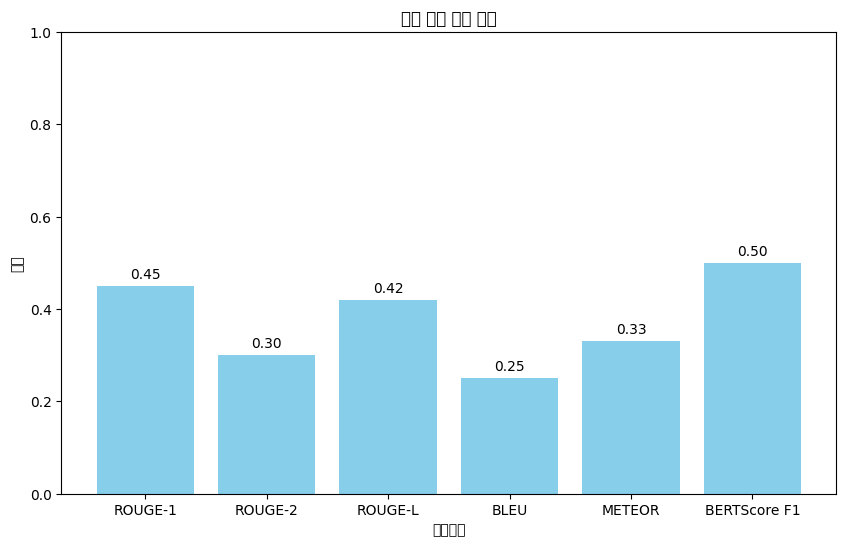

In [ ]:
import matplotlib.pyplot as plt

# 예시: 각 평가지표의 결과 (실제 결과 값으로 대체)
evaluation_metrics = {
    "ROUGE-1": 0.45,
    "ROUGE-2": 0.30,
    "ROUGE-L": 0.42,
    "BLEU": 0.25,
    "METEOR": 0.33,
    "BERTScore F1": 0.50
}

def plot_evaluation_metrics(metrics):
    # 지표 이름과 점수를 분리
    labels = list(metrics.keys())
    scores = list(metrics.values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, scores, color="skyblue")
    plt.xlabel("평가지표")
    plt.ylabel("점수")
    plt.title("요약 모델 평가 지표")
    
    # 각 막대 위에 점수 값을 표시
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')
    
    plt.ylim(0, 1)  # 점수 범위가 0~1이면
    plt.show()

plot_evaluation_metrics(evaluation_metrics)